<a href="https://www.kaggle.com/code/alecparrott/swimming-pool-detection-training?scriptVersionId=179401394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import cv2
from pathlib import Path
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
labels_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/labels/' 
images_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/images/'
train_images2_dir = '/kaggle/input/swimming-pool-detection-in-satellite-images/swimmingPool/training/images/'
train_labels2_dir = '/kaggle/input/swimming-pool-detection-in-satellite-images/swimmingPool/training/labels/'
test_images2_dir = '/kaggle/input/swimming-pool-detection-in-satellite-images/swimmingPool/testing/images/'
test_labels2_dir = '/kaggle/input/swimming-pool-detection-in-satellite-images/swimmingPool/testing/labels/'
root_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/'

In [3]:
import shutil

combined_dir = '/kaggle/working/combined_images/'

if not os.path.exists(combined_dir):
    os.mkdir(combined_dir)
    
    
for dir in [images_dir, train_images2_dir]:
    for filename in os.listdir(dir):
        shutil.copy(os.path.join(dir, filename), combined_dir)

In [4]:
print(len(os.listdir(combined_dir)))

2282


In [5]:
train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.RandomCrop(height=128, width=128, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
    A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.Rotate(limit=30, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Match training normalization
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [6]:
def show_transformed_image(dataset, idx):
    """
    Display a transformed image from the dataset along with its bounding boxes.

    Args:
        dataset (pool_sat_Dataset): The dataset object.
        idx (int): The index of the image to display.

    Returns:
        None
    """
    image, target = dataset[idx]
    image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = image.numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    print(target)
    for bbox in target['boxes']:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


In [7]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_data = {
        "filename": root.find('filename').text,
        "width": int(root.find('size/width').text),
        "height": int(root.find('size/height').text),
        "depth": int(root.find('size/depth').text),
        "xmin": [],
        "ymin": [],
        "xmax": [],
        "ymax": []
    }

    valid_image = True  # Assume image is valid unless a bounding box proves otherwise

    for obj in root.findall('object'):
        xmin = float(obj.find('bndbox/xmin').text)
        ymin = float(obj.find('bndbox/ymin').text)
        xmax = float(obj.find('bndbox/xmax').text)
        ymax = float(obj.find('bndbox/ymax').text)

        # Invalidate this image if xmin or ymin are zero
        if xmin == 0 or ymin == 0:
            valid_image = False
            break  # No need to check further; one invalid box is enough

        image_data["xmin"].append(xmin)
        image_data["ymin"].append(ymin)
        image_data["xmax"].append(xmax)
        image_data["ymax"].append(ymax)

    if not valid_image:
        return None  # Return None to indicate this image should be skipped

    return image_data

In [8]:
all_images = []

for label_dir in [labels_dir, train_labels2_dir]:
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.xml'):
            xml_path = os.path.join(label_dir, label_file)
            image_data = parse_xml(xml_path)
            if image_data:  # Only add if parse_xml returns valid data
                all_images.append(image_data)

df = pd.DataFrame(all_images)
print(df.head(10))
print(df.tail(10))

  filename  width  height  depth                              xmin  \
0  128.PNG    227     185      3  [17.0, 73.0, 98.0, 137.0, 163.0]   
1  147.PNG    218     242      3                     [30.0, 125.0]   
2  142.PNG    309     167      3                           [132.0]   
3  127.PNG    227     186      3                            [61.0]   
4  164.PNG    194     199      3                            [53.0]   
5   84.PNG    115     208      3                            [48.0]   
6  169.PNG    252     236      3                           [191.0]   
7  166.PNG    237     148      3                            [45.0]   
8  120.PNG    257     141      3                    [112.0, 175.0]   
9  109.PNG    303     165      3                            [83.0]   

                               ymin                                xmax  \
0  [21.0, 63.0, 90.0, 120.0, 144.0]  [49.0, 104.0, 129.0, 170.0, 196.0]   
1                     [62.0, 200.0]                       [68.0, 164.0]   
2   

In [9]:
print(df.describe())
print(df.isnull().sum())

for index, row in df.iterrows():
    image_path = os.path.join(combined_dir, row['filename'])
    if not os.path.exists(image_path):
        print(f"Image file {row['filename']} does not exist in {combined_dir}")

             width       height   depth
count  1318.000000  1318.000000  1318.0
mean    223.613050   219.369499     3.0
std      29.328432    24.937813     0.0
min      55.000000    67.000000     3.0
25%     224.000000   224.000000     3.0
50%     224.000000   224.000000     3.0
75%     224.000000   224.000000     3.0
max     566.000000   403.000000     3.0
filename    0
width       0
height      0
depth       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64


In [10]:
# Split the DataFrame into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
from torchvision.transforms.functional import to_tensor

class PoolDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Image loading
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert to numpy array first because using Albumentations

        # Bounding boxes
        xmin = self.dataframe.iloc[idx]['xmin']
        ymin = self.dataframe.iloc[idx]['ymin']
        xmax = self.dataframe.iloc[idx]['xmax']
        ymax = self.dataframe.iloc[idx]['ymax']
        boxes = torch.as_tensor([list(b) for b in zip(xmin, ymin, xmax, ymax)], dtype=torch.float32)
        labels = [1] * len(boxes)
        
        # Labels (as long as all boxes are pools, labels are 1; background is 0 and implicit)
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            transformed = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = transformed['bboxes']
            target['labels'] = transformed['labels']

        # Convert to tensors 
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)

        return image, target

In [12]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None and item[1]['boxes'].size(0) > 0]
    if not batch:
        return torch.tensor([]), []  # Return empty tensors if all items are filtered out
    images = torch.stack([item[0] for item in batch])
    targets = [{'boxes': item[1]['boxes'], 'labels': item[1]['labels']} for item in batch]
    return images, targets

In [13]:
# Initialize dataset
train_dataset = PoolDataset(train_df, combined_dir, train_transforms)
test_dataset = PoolDataset(test_df, combined_dir, test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, collate_fn=collate_fn)

In [14]:
import torchvision.ops as ops

def calculate_iou(boxA, boxes):
    """
    Calculate the IoU of one bounding box with a batch of bounding boxes.
    
    Args:
        boxA: A single bounding box.
        boxes: A tensor of bounding boxes.
        
    Returns:
        A tensor of IoU values.
    """
    xA = torch.max(boxA[0], boxes[:, 0])
    yA = torch.max(boxA[1], boxes[:, 1])
    xB = torch.min(boxA[2], boxes[:, 2])
    yB = torch.min(boxA[3], boxes[:, 3])

    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
    return iou

def soft_nms(boxes, scores, iou_threshold=0.5, score_threshold=0.001, sigma=0.5):
    """
    Apply Soft Non-Maximum Suppression to the predictions.
    Args:
        boxes (Tensor):  Tensor of shape (N, 4), containing the coordinates of N bounding boxes.
        scores (Tensor): Tensor of shape (N,), containing the confidence scores for each box.
        iou_threshold (float): The IoU threshold for NMS.
        score_threshold (float): The score threshold to discard low confidence boxes.
        sigma (float): The sigma parameter for Soft-NMS.
    Returns:
        keep (Tensor): Tensor of shape (K,), indices of the boxes kept after Soft-NMS.
    """
    boxes = boxes.float()
    scores = scores.float()

    keep = torch.tensor([], dtype=torch.int64)
    if boxes.numel() == 0:
        return keep

    # Use argsort to sort scores from highest to lowest
    order = scores.argsort(descending=True)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    while order.numel() > 0:
        i = order[0]
        keep = torch.cat([keep, torch.tensor([i])])

        if order.numel() == 1:
            break

        # Calculate IoU for the highest score box with every other remaining box 
        ious = calculate_iou(boxes[i:i+1], boxes[order[1:]])

        # Apply Soft-NMS score adjustment
        weight = torch.exp(-(ious**2) / sigma)
        scores[order[1:]] = scores[order[1:]] * weight.squeeze()

  
        # Filter out boxes with scores below threshold
        ids = (scores[order[1:]] > score_threshold).nonzero().squeeze()
  
        if ids.numel() == 0:
            break
  
        order = order[ids + 1]  # remove the first index to avoid duplicate
    
    return keep

# Function to calculate mean average precision (mAP)
def calculate_mAP(all_predictions, all_targets):
    ap_sum = 0.0
    num_classes = len(all_predictions[0])
    for class_idx in range(num_classes):
        predictions = [pred[class_idx] for pred in all_predictions]
        targets = [target[class_idx] for target in all_targets]
        average_precision = calculate_average_precision(predictions, targets)
        ap_sum += average_precision
    mAP = ap_sum / num_classes
    return mAP

# Function to calculate average precision for a single class
def calculate_average_precision(predictions, targets):
    sorted_indices = torch.argsort(predictions[:, -1], descending=True)
    predictions = predictions[sorted_indices]
    true_positives = torch.zeros(predictions.shape[0], dtype=torch.float32)
    false_positives = torch.zeros(predictions.shape[0], dtype=torch.float32)
    for i, prediction in enumerate(predictions):
        overlaps = calculate_iou(prediction[:-1], targets[:, :-1])
        assigned_target = torch.argmax(overlaps)
        max_overlap = overlaps[assigned_target]
        true_positives[i] = (max_overlap > 0.5) and (targets[assigned_target][-1] == 1)
        false_positives[i] = (max_overlap > 0.5) and (targets[assigned_target][-1] == 0)
    
    # Compute cumulative true positives and false positives
    cum_true_positives = torch.cumsum(true_positives, dim=0)
    cum_false_positives = torch.cumsum(false_positives, dim=0)
    
    # Compute recall (true positives) and precision (true positives / (true positives + false positives))
    recall = cum_true_positives / (torch.sum(targets[:, -1]) + 1e-6)
    precision = cum_true_positives / (cum_true_positives + cum_false_positives + 1e-6)
    
    # Calculate AP using the precision-recall curve
    precision = torch.cat((torch.tensor([1.0]), precision, torch.tensor([0.0])))
    recall = torch.cat((torch.tensor([0.0]), recall, torch.tensor([1.0])))
    for i in range(precision.size(0) - 1, 0, -1):
        precision[i] = torch.max(precision[i], precision[i + 1])
    ap = torch.sum((recall[1:] - recall[:-1]) * precision[:-1])
    
    return ap.item()

In [15]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torch.optim.lr_scheduler import StepLR

model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,  progress=True)
num_classes = 2  # 1 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 40

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 143MB/s]  


In [16]:
train_losses = []

all_predictions = []
all_targets = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    num_samples = 0
    
        # Calculate mean AP after each epoch
    if epoch % 5 == 0:
        mean_ap = calculate_mAP(all_predictions, all_targets)
        print(f"Epoch [{epoch+1}/{num_epochs}] Mean AP: {mean_ap}")
        # Reset lists to store predictions and targets for next evaluation
        all_predictions = []
        all_targets = []
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass: compute the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass: compute gradient and do SGD step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Convert to numpy arrays for convenience
        boxes = [t['boxes'].cpu().numpy() for t in model.roi_heads.post_process(loss_dict, images)[0]]
        labels = [t['labels'].cpu().numpy() for t in model.roi_heads.post_process(loss_dict, images)[0]]
        scores = [t['scores'].cpu().numpy() for t in model.roi_heads.post_process(loss_dict, images)[0]]

        # Apply Soft-NMS to the predicted boxes
        for i in range(len(boxes)):
            keep = soft_nms(torch.tensor(boxes[i]), torch.tensor(scores[i]), iou_threshold=0.5)
            boxes[i] = boxes[i][keep]
            labels[i] = labels[i][keep]
            scores[i] = scores[i][keep]

        # Store predictions and targets for mAP calculation
        all_predictions.append([torch.cat([torch.tensor(boxes[i]), torch.tensor(scores[i]).unsqueeze(1)], dim=1) for i in range(len(boxes))])  
        all_targets.append([torch.cat([torch.tensor(t['boxes']), torch.tensor(t['labels']).unsqueeze(1)], dim=1) for t in targets])
 

        train_losses.append(losses.item())      
        running_loss += losses.item()       
        
        # Update the learning rate    
        lr_scheduler.step()  
    
    # Print average loss for the epoch
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader)}")

Epoch 1 Loss: 0.26069438203491946
Epoch 2 Loss: 0.20210449846292083
Epoch 3 Loss: 0.19598914081738752
Epoch 4 Loss: 0.18884449596093458
Epoch 5 Loss: 0.17979841213673353
Epoch 6 Loss: 0.16763095930218697
Epoch 7 Loss: 0.17330058088356798
Epoch 8 Loss: 0.15715993229638447
Epoch 9 Loss: 0.14643431234766136
Epoch 10 Loss: 0.14115233380686154
Epoch 11 Loss: 0.13875519966875965
Epoch 12 Loss: 0.13862301807173275
Epoch 13 Loss: 0.1410646458918398
Epoch 14 Loss: 0.12499000360681252
Epoch 15 Loss: 0.11560200709341602
Epoch 16 Loss: 0.11205055352977732
Epoch 17 Loss: 0.11108535913411867
Epoch 18 Loss: 0.11260594452985308
Epoch 19 Loss: 0.11637563080611554
Epoch 20 Loss: 0.10990732514553449
Epoch 21 Loss: 0.0952925155447288
Epoch 22 Loss: 0.09047991528429768
Epoch 23 Loss: 0.08336845810779116
Epoch 24 Loss: 0.08224875890565189
Epoch 25 Loss: 0.07898013628172604
Epoch 26 Loss: 0.07871913524683226
Epoch 27 Loss: 0.08418700149790807
Epoch 28 Loss: 0.07838420751927928
Epoch 29 Loss: 0.07137829018756

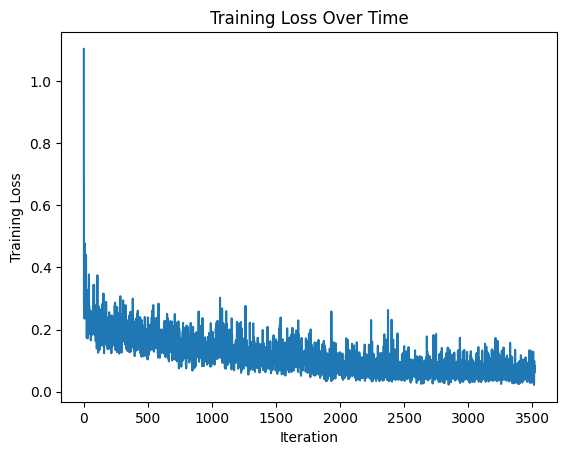

In [17]:
# Plot the training loss
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

In [19]:
torch.save(model.state_dict(), 'trained_fasterrcnn_model.pt')

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer  
    y=MultiLabelBinarizer().fit_transform(y)  


# Assuming 'device' is defined as 'cuda' if available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Make sure to replace the classifier head for your number of classes
num_classes = 2  # 1 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load your trained model weights
model.load_state_dict(torch.load('trained_fasterrcnn_model.pt', map_location=device))

# Move the model to the specified device
model.to(device)

# Set the model to evaluation mode
model.eval()
    
# Perform testing and calculate the metrics
predictions = []
true_labels = []
with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        true_labels.extend([target['labels'].tolist() for target in targets])
        
        outputs = model(images)
        predictions.extend([o['labels'].tolist() for o in outputs])

# Example: Using accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")  

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.